## Multiobjective parameter estimation

# Example: Buck converter

Example created by Gabriel Bueno Leandro

<div style="text-align: justify"> A buck converter is a type of DC/DC converter that steps down the voltage from its input to its output while increasing the current. It is a type of switched-mode power supply (SMPS) that typically contains at least two semiconductors, such as a diode and a transistor, and at least one energy storage element, such as a capacitor or inductor. Modern buck converters often replace the diode with a second transistor for synchronous rectification. Buck converters are similar to boost converters, which step up the voltage from their input to their output. </div>

## Reference 

**For further information, check this reference: https://doi.org/10.1080/00207170601185053**.

In [1]:
# Importing the libraries and methods needed to run the notebook.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.multiobjective.multiobjective_parameter_estimation import IM
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_results
from sysidentpy.metrics import root_relative_squared_error

# Dynamic Behavior

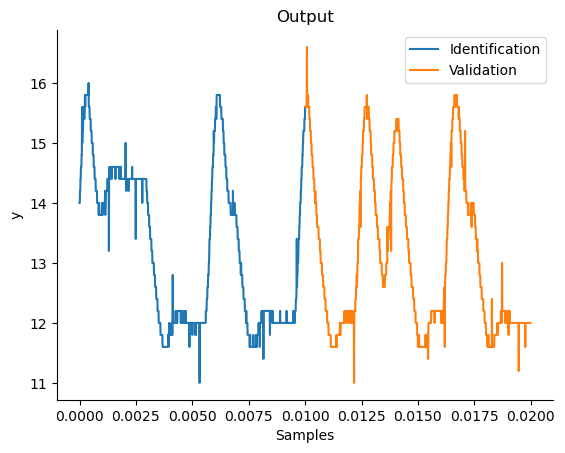

In [2]:
# Reading Buck's input and output data
data_train = pd.read_csv(r'datasets/buck.txt' , sep=" ", header=None).to_numpy()
data_valid = pd.read_csv(r'datasets/buck_val.txt' , sep =" ", header=None).to_numpy()

# Separating the identification data
data_samples_train = data_train[:, 2]
data_out_train = data_train[:, 6]
data_int_train = data_train[:, 4]

# Separating the validation data
data_samples_valid = data_valid[:, 2]
data_out_valid = data_valid[:, 6]
data_int_valid = data_valid[:, 4]

# Plotting the measured output (identification and validation data)
plt.figure(1)
plt.title('Output')
plt.plot(data_samples_train, data_out_train, label='Identification', linewidth=1.5)
plt.plot(data_samples_valid, data_out_valid , label='Validation', linewidth=1.5)
plt.xlabel('Samples')
plt.ylabel('y')
plt.legend()
plt.show()


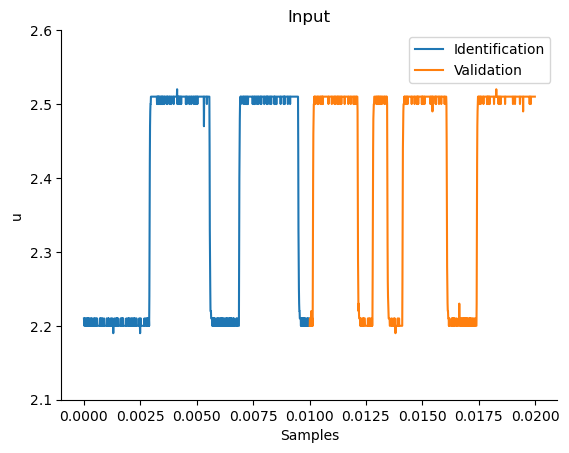

In [3]:
# Plotting the measured input(identification and validation data)
plt.figure(2)
plt.title('Input')
plt.plot(data_samples_train, data_int_train, label='Identification', linewidth=1.5)
plt.plot(data_samples_valid, data_int_valid, label='Validation', linewidth=1.5)
plt.ylim(2.1, 2.6)
plt.ylabel('u')
plt.xlabel('Samples')
plt.legend()
plt.show()

## Buck Converter Static Function

The duty cycle, represented by the symbol $D$, is defined as the ratio of the time the system is on ($T_{on}$​) to the total operation cycle time ($T$). Mathematically, this can be expressed as $D=\frac{T_{on}}{T}$. The complement of the duty cycle, represented by $D'$, is defined as the ratio of the time the system is off ($T_{off}$) to the total operation cycle time ($T$) and can be expressed as $D'=\frac{T_{off}}{T}$.

The load voltage ($V_o$) is related to the source voltage ($V_d$) by the equation $V_o​=D⋅V_d​=(1−D’)⋅V_d$.  For this particular converter, it is known that $D′=\frac{\bar{u}-1}{3}​$,​ which means that the static function of this system can be derived from theory to be:

$$
V_o = \frac{4V_d}{3} - \frac{V_d}{3}\cdot \bar{u}
$$

If we assume that the source voltage $V_d$​ is equal to 24 V, then we can rewrite the above expression as follows:

$$
V_o = (4 - \bar{u})\cdot 8
$$

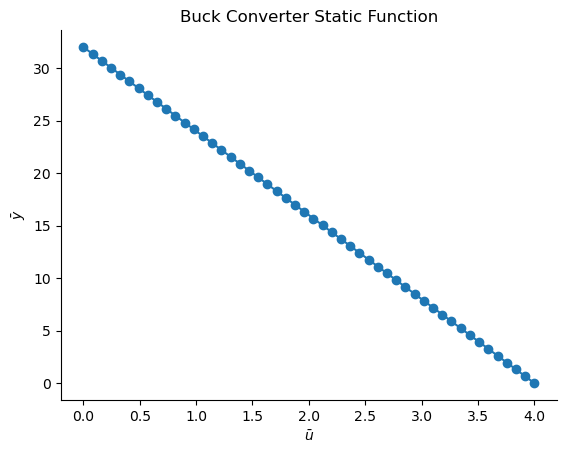

In [4]:
# Static data
Vd = 24
Uo = np.linspace(0, 4, 50)
Yo = (4-Uo)*Vd/3
Uo = Uo.reshape(-1, 1)
Yo = Yo.reshape(-1, 1)
plt.figure(3)
plt.title('Buck Converter Static Function')
plt.xlabel('$\\bar{u}$')
plt.ylabel('$\\bar{y}$')
plt.plot(Uo, Yo, linewidth=1.5, linestyle='-', marker='o')
plt.show()

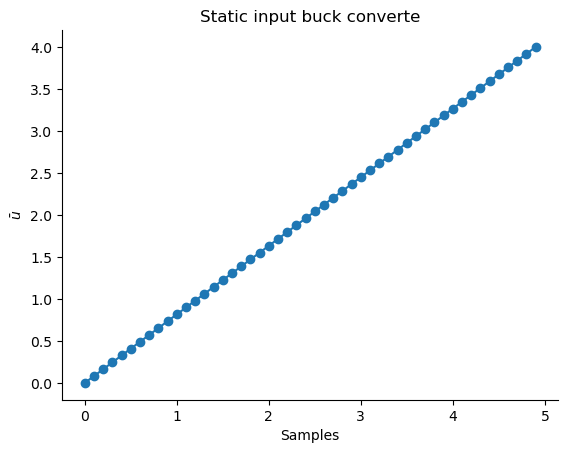

In [5]:
plt.figure(3)
samples = np.arange(0, 5, 5/len(Uo))
plt.title('Static input buck converte')
plt.ylabel('$\\bar{u}$')
plt.xlabel('Samples')
plt.plot(samples, Uo, linewidth=1.5, linestyle='-', marker='o')
plt.show()

# Buck converter static gain

The gain of a Buck converter is a measure of how its output voltage changes in response to changes in its input voltage. Mathematically, the gain can be calculated as the derivative of the converter’s static function, which describes the relationship between its input and output voltages.
In this case, the static function of the Buck converter is given by the equation:

$$
V_o = (4 - \bar{u})\cdot 8
$$

Taking the derivative of this equation with respect to $\hat{u}$, we find that the gain of the Buck converter is equal to −8. In other words, for every unit increase in the input voltage $\hat{u}$, the output voltage Vo​ will decrease by 8 units.

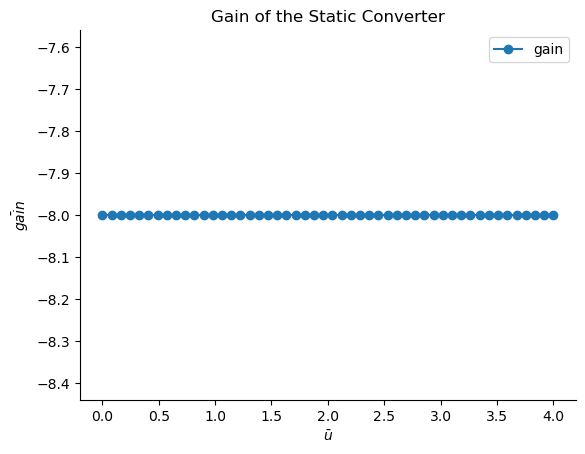

In [6]:
# Defining the gain
gain = -8*np.ones(len(Uo)).reshape(-1, 1)
plt.figure(3)
plt.title('Gain of the Static Converter')
plt.xlabel('$\\bar{u}$')
plt.ylabel('$\\bar{gain}$')
plt.plot(Uo, gain, linewidth=1.5, label='gain', linestyle='-', marker='o')
plt.legend()
plt.show()

Information about the static function and static gain of a system, along with its usual input/output data, can be used as sources of affine information to estimate the parameters of a mathematical model. In this context, a composite cost function is often used to measure the accuracy of the estimated model parameters. This cost function is typically defined as a weighted sum of several individual cost functions, each representing a different aspect of the model’s performance.

In this case, the composite cost function is given by the equation:

$$
\gamma(\hat\theta) = w_1\cdot J_{LS}(\hat{\theta})+w_2\cdot J_{SF}(\hat{\theta})+w_3\cdot J_{SG}(\hat{\theta})
$$

where $\hat{\theta}$ represents the estimated model parameters, $w_1$​, $w_2$​, and $w_3$ are weighting factors, and $J_{LS}$​, $J_{SF}$​, and $J_{SG}$ are individual cost functions representing the least squares, static function, and static gain aspects of the model’s performance, respectively.


In [7]:
# Informing test and validation data
x_train = data_int_train.reshape(-1, 1)
y_train = data_out_train.reshape(-1, 1)
x_valid = data_int_valid.reshape(-1, 1)
y_valid = data_out_valid.reshape(-1, 1)

basis_function = Polynomial(degree=2)

model = FROLS(
    order_selection=True,
    n_info_values=8,
    extended_least_squares=False,
    ylag=2, xlag=2,
    info_criteria='aic',
    estimator='least_squares',
    basis_function=basis_function
)

model.fit(X=x_train, y=y_train)

C:\Users\55359\OneDrive\Área de Trabalho\Clone_git\sysidentpy\sysidentpy\utils\deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)


with the parameters all in hand, we can already calculate the parameters in a multiobjective way:

In [8]:
# Calling the class referring to the calculation of the parameters via the multiobjective technique
mult = IM(model_type=model.model_type,
       final_model = model.final_model)

The method will now be called to perform several calculations related to the performance of the objectives. These calculations include the computation of the performance matrix (J), the weights matrix (w), the Euclidean norm (E), and the values of $\theta$ for each weight. Additionally, the method will also calculate the product of matrix H and matrix R, as well as the product of matrix Q and matrix R.

In [9]:
# Method to calculate the parameters
J, w, E, Theta, HR, QR, position = mult.affine_information_least_squares(y_train=y_train[2:],
                                                                         gain=gain,y_static=Yo,
                                                                         x_static=Uo, psi=model.psi)
result = {'w1': w[0,:],
          'w2': w[2,:],
          'w3': w[1,:],
          'J_ls': J[0,:],
          'J_sg': J[1,:],
          'J_sf': J[2,:],
          '||J||:': E}
pd.DataFrame(result)

,w1,w2,w3,J_ls,J_sg,J_sf,||J||:
0,0.990080,0.003078,0.006842,0.992584,9.825995e-02,0.305492,0.261455
1,0.990080,0.002347,0.007573,0.991990,1.551666e-01,0.266591,0.286111
2,0.990080,0.001538,0.008382,0.990885,3.048969e-01,0.220806,0.382836
3,0.990080,0.000642,0.009277,0.988248,1.000000e+00,0.142808,1.000000
4,0.894495,0.098663,0.006842,0.995100,1.364999e-03,0.660485,0.244160
...,...,...,...,...,...,...,...
2290,0.006842,0.333527,0.659632,0.999976,5.944270e-08,0.000020,0.245246
2291,0.006842,0.263039,0.730119,0.999985,6.124624e-08,0.000018,0.245248
2292,0.006842,0.185020,0.808139,0.999993,6.466930e-08,0.000016,0.245250
2293,0.006842,0.098663,0.894495,1.000000,7.400899e-08,0.000015,0.245252


at this point, we can select a value for $\theta$ that corresponds to the weights in our model. This value of $\theta$ will determine the relative importance of each objective in the performance matrix, and will affect the overall performance of the model.

In [10]:
# Writing the results
model.theta = Theta[position, :].reshape(-1,1)
yhat = model.predict(X=x_valid, y=y_valid)
rrse = root_relative_squared_error(y_valid, yhat)
r = pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=3, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
r

,Regressors,Parameters,ERR
0,y(k-1),2.9687E-01,9.999E-01
1,y(k-2),6.4693E-01,2.042E-05
2,x1(k-1)y(k-1),4.0624E-03,1.108E-06
3,1,1.5405E+00,4.688E-06
4,y(k-1)^2,2.7671E-01,3.922E-07
5,x1(k-1),-4.1302E-01,8.389E-07
6,y(k-2)y(k-1),-5.3474E-01,5.690E-07
7,y(k-2)^2,2.5832E-01,3.827E-06


dynamic data in graphical form:

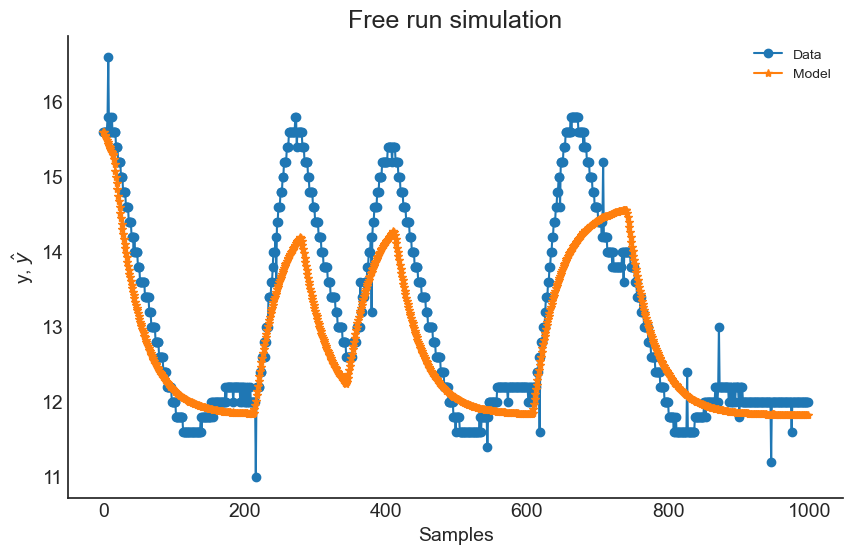

In [11]:
plot_results(y=y_valid, yhat=yhat, n=1000)

The static gain of a system can be represented graphically to provide a visual representation of how the system’s output changes in response to changes in its input. This graphical representation can be useful for understanding the behavior of the system and for designing control strategies.

To create a graphical representation of the static gain, the input variable is typically plotted on the horizontal axis, while the corresponding changes in the output variable are plotted on the vertical axis. The resulting graph shows how the output variable changes as the input variable is varied, providing a visual representation of the system’s static gain.

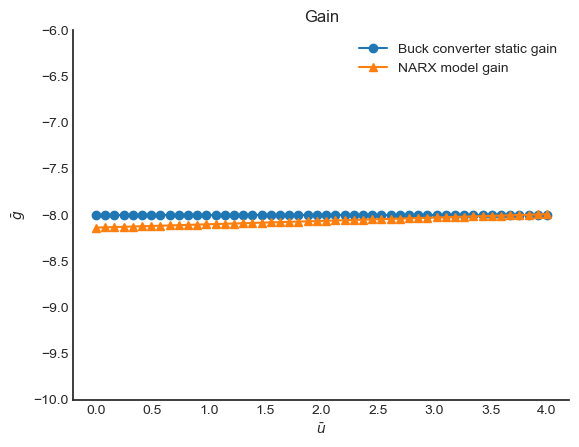

In [12]:
plt.figure(4)
plt.title('Gain')
plt.plot(Uo, gain, linewidth=1.5, linestyle='-', marker='o', label='Buck converter static gain')
plt.plot(Uo, HR.dot(model.theta),  linestyle='-', marker='^', linewidth=1.5, label='NARX model gain')
plt.xlabel('$\\bar{u}$')
plt.ylabel('$\\bar{g}$')
plt.ylim(-10, -6)
plt.legend()
plt.show()

The static function of a system can be represented graphically to provide a visual representation of the relationship between the system’s input and output. This graphical representation can be useful for understanding the behavior of the system and for designing control strategies.

To create a graphical representation of the static function, the input variable is typically plotted on the horizontal axis, while the corresponding output variable is plotted on the vertical axis. The resulting graph shows how the output variable changes as the input variable is varied, providing a visual representation of the system’s static function.

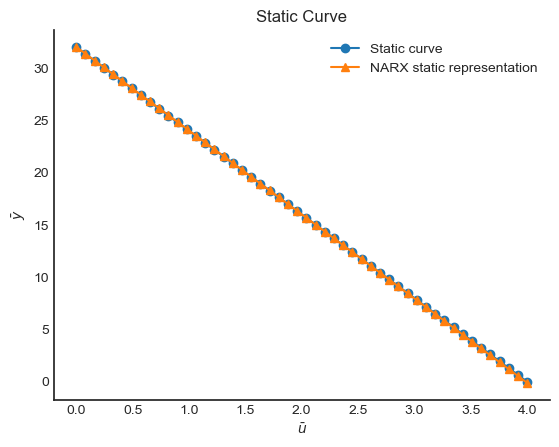

In [13]:
plt.figure(5)
plt.title('Static Curve')
plt.plot(Uo, Yo, linewidth=1.5, label='Static curve',  linestyle='-', marker='o')
plt.plot(Uo, QR.dot(model.theta), linewidth=1.5, label='NARX ​​static representation', linestyle='-', marker='^')
plt.xlabel('$\\bar{u}$')
plt.ylabel('$\\bar{y}$')
plt.legend()
plt.show()

A Pareto-optimal curve, also known as a Pareto frontier, is a graphical representation of the trade-offs between multiple objectives in a multi-objective optimization problem. The curve shows the set of solutions that are considered optimal, in the sense that no other solution can improve one objective without worsening at least one other objective.

To create a Pareto-optimal curve, the values of the different objectives are typically plotted on different axes, with each point on the curve representing a solution that is optimal with respect to the trade-offs between the objectives. The shape of the curve can provide insight into the nature of the trade-offs between the objectives and can help decision-makers to identify solutions that best meet their needs and preferences.

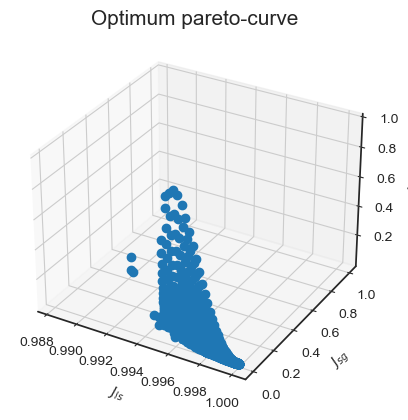

In [14]:
plt.figure(6)
ax = plt.axes(projection='3d')
ax.plot3D( J[0,:],  J[1,:],  J[2,:], 'o', linewidth=0.1)
ax.set_title('Optimum pareto-curve', fontsize=15)
ax.set_xlabel('$J_{ls}$', fontsize=10)
ax.set_ylabel('$J_{sg}$', fontsize=10)
ax.set_zlabel('$J_{sf}$', fontsize=10)
plt.show()